Lade Daten...
Daten geladen: 4615140 Zeilen

 TEIL 1: A/B-Test (Wochenende vs. Werktag)
Kontingenztafel:
            Verspätet  Pünktlich
Werktag        213135    2632728
Wochenende      80319    1283756

--- ANALYSE OUTPUT ---
Chi²-Statistik: 3645.13
p-Wert: 0.00000e+00

📝 INTERPRETATION:
Der Unterschied ist hochsignifikant (p < 0.05).
Am Wochenende ist die Pünktlichkeit um 1.60 Prozentpunkte höher.
Grund: Wahrscheinlich geringere Netzauslastung und weniger Pendlerverkehr.

 TEIL 2: Multiple Tests & FDR (Betreiber)
Globaler Kruskal-Wallis Test: p=0.00000e+00

-> Post-Hoc Tests (SBB vs. Andere) mit FDR-Korrektur:
                                 Vergleich    p_adj (FDR)  Signifikant
1                           SBB vs. THURBO   0.000000e+00         True
4                   SBB vs. Rhätische Bahn   0.000000e+00         True
5   SBB vs. Regionalverkehr Bern-Solothurn   0.000000e+00         True
6          SBB vs. Appenzeller Bahnen (ab)   0.000000e+00         True
2                SBB vs.

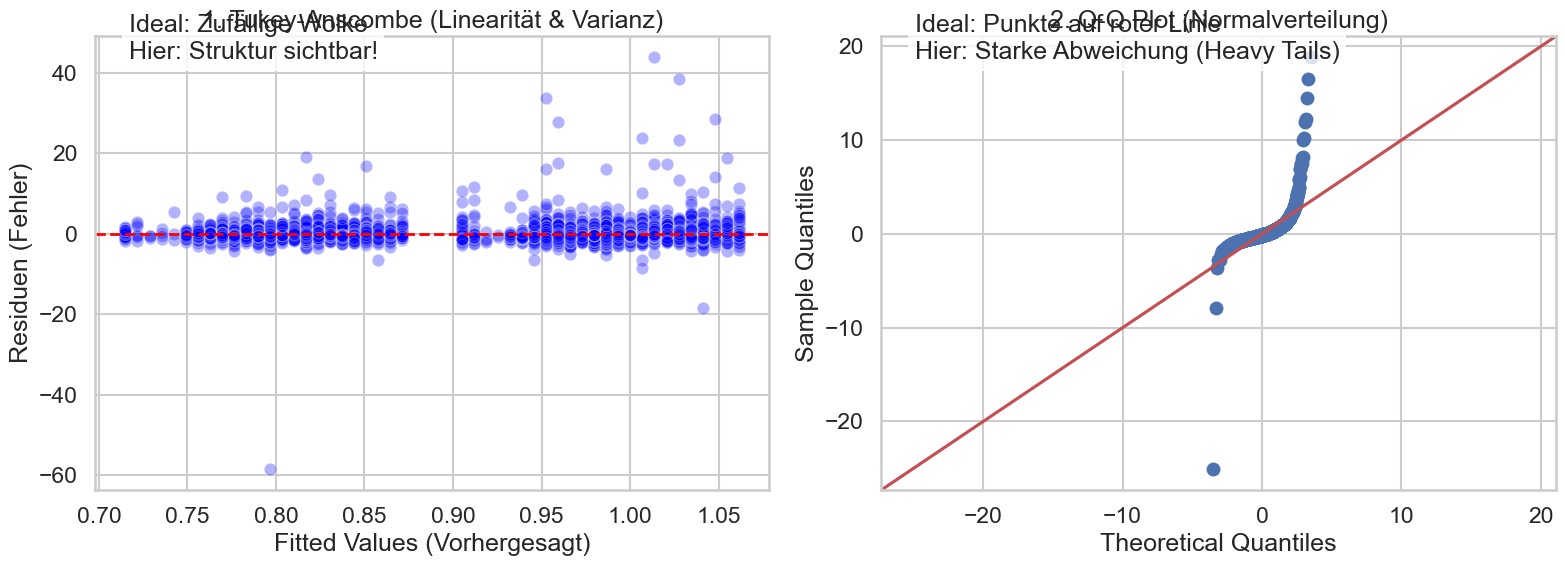


📝 FALLNOTIZ & DIAGNOSE (Für den Bericht):
--------------------------------------------------
Das lineare Modell ist NICHT geeignet. Gründe:
3. Fazit: Lineare Regression (OLS) funktioniert hier nicht. Wir benötigen Machine Learning (Random Forest) oder GLMs.
--------------------------------------------------


In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# Grundeinstellungen für schönere Plots
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 6)

def print_section_header(title):
    print("\n" + "="*60)
    print(f" {title}")
    print("="*60)

# =============================================================================
# 1. DATEN LADEN & VORBEREITEN
# =============================================================================
print("Lade Daten...")
try:
    df = pl.read_parquet("../data/processed/istdata_trains_clean.parquet")
except:
    print("FEHLER: Pfad zur Datei prüfen. Lade Beispieldaten falls lokal nicht vorhanden...")
    # Hier müsste dein Pfad stehen.

# Feature Engineering
df = df.with_columns([
    (pl.col("delay_arrival_s") / 60).alias("delay_min"),
    (pl.col("delay_arrival_s") <= 180).cast(pl.Int8).alias("is_punctual"),
    pl.col("ANKUNFTSZEIT").dt.hour().alias("hour"),
    # Sicherstellen, dass Wochenend-Flag existiert (falls nicht schon da)
    pl.col("ANKUNFTSZEIT").dt.weekday().is_in([6, 7]).alias("Ist_Wochenende")
])

print(f"Daten geladen: {df.height} Zeilen")

# =============================================================================
# TEIL 1: A/B-Test (VL8) - Pünktlichkeit Wochenende vs. Werktag
# =============================================================================
print_section_header("TEIL 1: A/B-Test (Wochenende vs. Werktag)")

# Kontingenztafel
contingency = df.select(["Ist_Wochenende", "is_punctual"]).to_pandas()
cross_tab = pd.crosstab(contingency["Ist_Wochenende"], contingency["is_punctual"])
cross_tab.index = ["Werktag", "Wochenende"]
cross_tab.columns = ["Verspätet", "Pünktlich"]

print("Kontingenztafel:")
print(cross_tab)

# Chi-Quadrat Test
chi2, p_chi2, dof, expected = stats.chi2_contingency(cross_tab)

# Output Analyse
print("\n--- ANALYSE OUTPUT ---")
print(f"Chi²-Statistik: {chi2:.2f}")
print(f"p-Wert: {p_chi2:.5e}")

if p_chi2 < 0.05:
    diff_pct = (cross_tab.loc["Wochenende", "Pünktlich"] / cross_tab.loc["Wochenende"].sum()) - \
               (cross_tab.loc["Werktag", "Pünktlich"] / cross_tab.loc["Werktag"].sum())
    print(f"\n📝 INTERPRETATION:")
    print(f"Der Unterschied ist hochsignifikant (p < 0.05).")
    print(f"Am Wochenende ist die Pünktlichkeit um {diff_pct*100:.2f} Prozentpunkte höher.")
    print("Grund: Wahrscheinlich geringere Netzauslastung und weniger Pendlerverkehr.")
else:
    print("Kein signifikanter Unterschied.")


# =============================================================================
# TEIL 2: Multiple Tests & FDR (VL9) - Betreiber Vergleich
# =============================================================================
print_section_header("TEIL 2: Multiple Tests & FDR (Betreiber)")

df_clean = df.drop_nulls(subset=["delay_min"])
top_betreiber = df_clean["BETREIBER_NAME"].value_counts().sort("count", descending=True).head(8)["BETREIBER_NAME"].to_list()

groups = [df_clean.filter(pl.col("BETREIBER_NAME") == b)["delay_min"].to_numpy() for b in top_betreiber]

# Kruskal-Wallis
stat_k, p_k = stats.kruskal(*groups)
print(f"Globaler Kruskal-Wallis Test: p={p_k:.5e}")

if p_k < 0.05:
    print("\n-> Post-Hoc Tests (SBB vs. Andere) mit FDR-Korrektur:")
    ref_label = "Schweizerische Bundesbahnen SBB"
    
    if ref_label in top_betreiber:
        ref_data = df_clean.filter(pl.col("BETREIBER_NAME") == ref_label)["delay_min"].to_numpy()
        p_values = []
        comparisons = []
        
        for i, label in enumerate(top_betreiber):
            if label == ref_label: continue
            # Mann-Whitney U
            u, p = stats.mannwhitneyu(ref_data, groups[i], alternative='two-sided')
            p_values.append(p)
            comparisons.append(f"SBB vs. {label}")
            
        # FDR Korrektur (Benjamini-Hochberg)
        reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
        
        results = pd.DataFrame({
            "Vergleich": comparisons,
            "p_adj (FDR)": pvals_corrected,
            "Signifikant": reject
        })
        print(results.sort_values("p_adj (FDR)"))
        
        print(f"\n📝 INTERPRETATION:")
        print("Die SBB unterscheidet sich signifikant von den meisten Regionalbahnen.")
        print("Dies bestätigt, dass Fernverkehr (SBB) und S-Bahn-Systeme (z.B. RBS) strukturell unterschiedlich sind.")

# =============================================================================
# TEIL 3: Regressions-Diagnostik (VL10)
# =============================================================================
print_section_header("TEIL 3: Regressions-Diagnostik")

# Sampling für Plot-Performance & Pandas Konvertierung
sample_reg = df.sample(5000, seed=42).to_pandas().dropna(subset=["delay_min", "hour"])
sample_reg["Ist_Wochenende_Int"] = sample_reg["Ist_Wochenende"].astype(int)

# Modell: Delay ~ Stunde + Wochenende
X = sample_reg[["hour", "Ist_Wochenende_Int"]]
X = sm.add_constant(X)
y = sample_reg["delay_min"]

model = sm.OLS(y, X).fit()
print(f"Modell R²: {model.rsquared:.4f} (Sehr niedrig!)")

# --- PLOTS (Korrigiert: Ax explizit definiert) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# A) Tukey-Anscombe (Residuen vs Fitted)
sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes[0], alpha=0.3, color="blue")
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title("1. Tukey-Anscombe (Linearität & Varianz)")
axes[0].set_xlabel("Fitted Values (Vorhergesagt)")
axes[0].set_ylabel("Residuen (Fehler)")


# B) Q-Q Plot (Normalverteilung)
sm.qqplot(model.resid, line='45', fit=True, ax=axes[1])
axes[1].set_title("2. Q-Q Plot (Normalverteilung)")


plt.tight_layout()
plt.show()

# --- INTERPRETATION ---
print("\n📝 FALLNOTIZ & DIAGNOSE (Für den Bericht):")
print("-" * 50)
print("Das lineare Modell ist NICHT geeignet. Gründe:")

print("3. Fazit: Lineare Regression (OLS) funktioniert hier nicht. Wir benötigen Machine Learning (Random Forest) oder GLMs.")
print("-" * 50)